Text(0, 0.5, 'C')

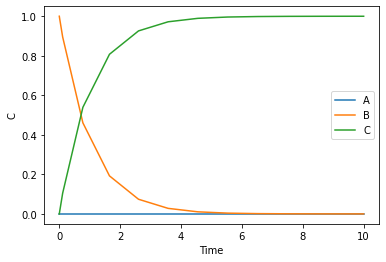

In [1]:
from scipy.integrate import solve_ivp

def ode(t, C):
    Ca, Cb, Cc = C
    dCadt = -k1 * Ca
    dCbdt = k1 * Ca - k2 * Cb
    dCcdt = k2 * Cb
    return [dCadt, dCbdt, dCcdt]

C0 = [0.0, 1.0, 0.0]
k1 = 1
k2 = 1

sol = solve_ivp(ode, (0, 10), C0)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y.T)
plt.legend(['A', 'B', 'C'])
plt.xlabel('Time')
plt.ylabel('C')

In [2]:
import autograd.numpy as np
from autograd import grad, elementwise_grad, jacobian
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def swish(x):
    "see https://arxiv.org/pdf/1710.05941.pdf"
    return x / (1.0 + np.exp(-x))

def C(params, inputs):
    "Neural network functions"
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = swish(outputs)
    return outputs

# initial guess for the weights and biases
params = init_random_params(0.1, layer_sizes=[1, 8, 3])

Text(0, 0.5, 'C')

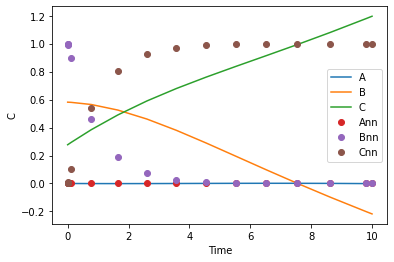

In [3]:
def objective_soln(params, step):
    return np.sum((sol.y.T - C(params, sol.t.reshape([-1, 1])))**2)

params = adam(grad(objective_soln), params,
              step_size=0.001, num_iters=500)

plt.plot(sol.t.reshape([-1, 1]), C(params, sol.t.reshape([-1, 1])),
         sol.t, sol.y.T, 'o')
plt.legend(['A', 'B', 'C', 'Ann', 'Bnn', 'Cnn'])
plt.xlabel('Time')
plt.ylabel('C')

In [4]:
jacC = jacobian(C, 1)
jacC(params, sol.t.reshape([-1, 1])).shape

(15, 3, 15, 1)

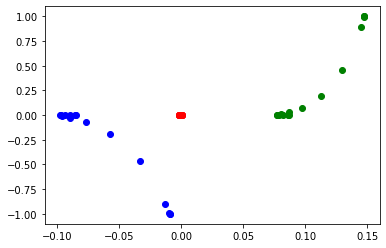

In [5]:
i = np.arange(len(sol.t))
plt.plot(jacC(params, sol.t.reshape([-1, 1]))[i, 0, i, 0],   -k1 * sol.y[0], 'ro')
plt.plot(jacC(params, sol.t.reshape([-1, 1]))[i, 1, i, 0],   -k2 * sol.y[1] + k1 * sol.y[0], 'bo')
plt.plot(jacC(params, sol.t.reshape([-1, 1]))[i, 2, i, 0],   k2 * sol.y[1], 'go')

In [6]:
# Derivatives
jac = jacobian(C, 1)
def dCdt(params, t):
    i = np.arange(len(t))
    return jac(params, t)[i, :, i].reshape((len(t), 3))

In [19]:
t = np.linspace(0, 2.61, 2611).reshape((-1, 1))
params = init_random_params(0.1, layer_sizes=[1, 8, 3])
i = 0    # number of training steps
N = 500  # epochs for training
et = 0.0 # total elapsed time
type(t)

numpy.ndarray

In [18]:
def objective(params, step):
    Ca, Cb, Cc = C(params, t).T
    dCadt, dCbdt, dCcdt = dCdt(params, t).T
    
    z1 = np.sum((dCadt + Ca)**2)
    z2 = np.sum((dCbdt - Ca + Cb)**2)
    z3 = np.sum((dCcdt - Cb)**2)

    ic = np.sum((np.array([Ca[0], Cb[0], Cc[0]]) - C0)**2)  # initial conditions
    return z1 + z2 + z3 + ic

def callback(params, step, g):
    if step % 100 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      objective(params, step)))

objective(params, 0)  # make sure the objective is scalar

126.69780471670744

0.0 minutes elapsed this time. Total time = 0.00 min. Total epochs = 500.


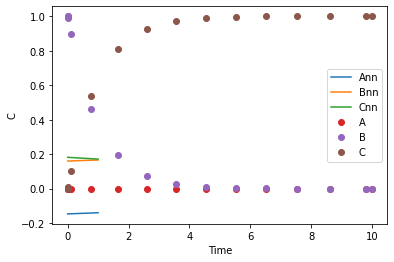

In [9]:
import time
t0 = time.time()

# params = adam(grad(objective), params,
#               step_size=0.005, num_iters=N, callback=callback)

i += N
t1 = (time.time() - t0) / 60
et += t1

plt.plot(t, C(params, t), sol.t, sol.y.T, 'o')
plt.legend(['Ann', 'Bnn', 'Cnn', 'A', 'B', 'C'])
plt.xlabel('Time')
plt.ylabel('C')
print(f'{t1:1.1f} minutes elapsed this time. Total time = {et:1.2f} min. Total epochs = {i}.')